## Problem Statement

### Business Context
Tuko is a media analysis firm specializing in providing data-driven insights and strategic consultation services to news organizations, advertisers, and academic entities interested in media studies. Utilizing advanced data science techniques, the company aims to offer comprehensive analysis and recommendations based on global news trends and patterns.

### Objective
The firm has access to a rich dataset comprising news articles from various global sources, website traffic data, and domain locations. This dataset is a gold mine for understanding the dynamics of news dissemination, audience engagement, and content sentiment across different regions and media platforms.  By correlating news sentiment with traffic data, Tuko can assess the impact of news events on consumer behavior and adjust their campaigns accordingly. They have engaged you as a data scientist to carry out the following:
- Perform exploratory data analysis (EDA) to uncover patterns, insights, and anomalies in the data.
- Conduct topic modeling and sentiment analysis on the news content.
- Design and implement a PostgreSQL database schema to store ML features.
- Load and manage data within PostgreSQL, using it as a feature store for ML models.


### Data Description
`data.csv:`

- article_id: Unique article id
- source_id
- source_name: Source name
- author: The author of the article
- title: The headline or title of the article.
- description: A description or snippet from the article. 
- url: The direct URL to the article. 
- url_to_image: The URL to a relevant image for the article.
- published_at: The date and time that the article was published, in UTC
- content: The unformatted content of the article, where available. This is truncated to 200 chars
- category: Search query used to fetch data
- article: Full content of that article
- title_sentiment: Sentiment of the title


`domains_location.csv:`

- SourceCommonName: Common  Domain Name (bbc.co.uk, cnn.com)
- location: Country short code (US, UK, CA)
- Country: Country name

`traffic_data.csv:`

- GlobalRank: Rank of the domain globally
- TldRank: Rank of the TLD (Top-Level Domain [.com, .org…..etc]) among other similar TLD (Top-Level Domain [.com, .org…..etc])
- Domain: 
TLD: TLD (Top-Level Domain [.com, .org…..etc])
RefSubNets: The number of Referring Subnets found for this domain in the Fresh Index.
RefIPs: The number of Referring IPs found for this domain in the Fresh Index.
IDN_Domain: Internationalized Domain Name
IDN_TLD: Internationalized Domain Name Top-Level Domain.
PrevGlobalRank: Previous Global Rank.
PrevTldRank: Previous TLD Rank.
PrevRefSubNets: Previous number of referring subnets.
PrevRefIPs: Previous number of referring IPs.

## Importing necessary libraries

In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

import os, sys

## Loading the dataset

In [2]:
trafficdf = pd.read_csv('traffic.csv')
ratingdf = pd.read_csv('rating.csv')
domaindf = pd.read_csv('domains_location.csv')

## Loader.py

In [3]:
if os.path.abspath("..") not in sys.path:
    sys.path.insert(0, os.path.abspath(".."))


from src.loader import NewsDataLoader

loader = NewsDataLoader()
news_data = loader.load_data('C:/Users/Jojo/Desktop/10A/10x/Week0-Cb/rating.csv')



## Data Overview

In [4]:
# first five rows of our rating dataset
ratingdf.head()

,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,category,article,title_sentiment
0,81664,NaN,Forbes,"Elizabeth Brownfield, Contributor, \n Elizabet...",superstar chef yannick alléno brings refined f...,Now open in Mayfair at Four Seasons Hotel Lond...,https://www.forbes.com/sites/elizabethbrownfie...,https://imageio.forbes.com/specials-images/ima...,2023-11-01 03:27:21.000000,"Pavyllon London, at Four Seasons Hotel London ...",Monaco,"pavyllon london, at four seasons hotel london ...",Neutral
1,81667,NaN,CNA,NaN,nice claim top spot in ligue 1 with late win a...,Nice moved into provisional first place in the...,https://www.channelnewsasia.com/sport/nice-cla...,https://onecms-res.cloudinary.com/image/upload...,2023-10-27 21:28:48.000000,Nice moved into provisional first place in the...,Monaco,nice moved into provisional first place in the...,Positive
2,81694,time,Time,Christina Larson / AP,amphibians are the world’s most vulnerable spe...,"The world’s frogs, salamanders, newts, and oth...",https://time.com/6320467/amphibians-most-vulne...,https://api.time.com/wp-content/uploads/2023/1...,2023-10-04 17:36:18.000000,"The worlds frogs, salamanders, newts and other...",Madagascar,"the world’s frogs, salamanders, newts and othe...",Negative
3,81695,NaN,Phys.Org,Sara Schmidt,image: rusty red waters in madagascar,Iron-rich sediment colors the red-orange water...,https://phys.org/news/2023-10-image-rusty-red-...,https://scx2.b-cdn.net/gfx/news/2023/image-rus...,2023-10-31 18:04:02.000000,Iron-rich sediment colors the red-orange water...,Madagascar,iron-rich sediment colors the red-orange water...,Neutral
4,81703,NaN,Digital Trends,Jason Struss,everything leaving max (formerly hbo max) in n...,From Gangs of London to Fear the Walking Dead ...,https://www.digitaltrends.com/movies/everythin...,https://www.digitaltrends.com/wp-content/uploa...,2023-10-23 23:09:18.000000,"Everything ends. No, I’m not having an existen...",Madagascar,"everything ends. no, i’m not having an existen...",Neutral


In [5]:
# first five rows of our domain location dataset
domaindf.head()

,SourceCommonName,location,Country
0,00221.info,SG,Senegal
1,01net.com,FR,France
2,01net.it,IT,Italy
3,0223.com.ar,AR,Argentina
4,022china.com,CH,China


In [6]:
# first five rows of our traffic dataset
trafficdf.head()

,GlobalRank,TldRank,Domain,TLD,RefSubNets,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs
0,1,1,google.com,com,471274,2151358,google.com,com,1,1,471248,2147402
1,2,2,facebook.com,com,465424,2250631,facebook.com,com,2,2,465297,2247135
2,3,3,youtube.com,com,420579,1852995,youtube.com,com,3,3,420483,1848940
3,4,4,twitter.com,com,404985,1757127,twitter.com,com,4,4,404998,1753939
4,5,5,instagram.com,com,364746,1598085,instagram.com,com,5,5,364618,1594892


In [7]:
# shape of our data
print('There are', ratingdf.shape[0], 'rows and', ratingdf.shape[1], 'columns in our ratingdf', '\n')


print('There are', domaindf.shape[0], 'rows and', domaindf.shape[1], 'columns in our domaindf', '\n')

print('There are', trafficdf.shape[0], 'rows and', trafficdf.shape[1], 'columns in our trafficdf')

There are 58356 rows and 13 columns in our ratingdf 

There are 37802 rows and 3 columns in our domaindf 

There are 1000000 rows and 12 columns in our trafficdf


In [8]:
print(ratingdf.columns, '\n')
print(domaindf.columns, '\n')
print(trafficdf.columns, '\n')


Index(['article_id', 'source_id', 'source_name', 'author', 'title',
       'description', 'url', 'url_to_image', 'published_at', 'content',
       'category', 'article', 'title_sentiment'],
      dtype='object') 

Index(['SourceCommonName', 'location', 'Country'], dtype='object') 

Index(['GlobalRank', 'TldRank', 'Domain', 'TLD', 'RefSubNets', 'RefIPs',
       'IDN_Domain', 'IDN_TLD', 'PrevGlobalRank', 'PrevTldRank',
       'PrevRefSubNets', 'PrevRefIPs'],
      dtype='object') 



In [9]:
# checking data types of our columns
ratingdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58356 entries, 0 to 58355
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_id       58356 non-null  int64 
 1   source_id        17771 non-null  object
 2   source_name      58356 non-null  object
 3   author           56193 non-null  object
 4   title            58356 non-null  object
 5   description      58346 non-null  object
 6   url              58356 non-null  object
 7   url_to_image     54905 non-null  object
 8   published_at     58356 non-null  object
 9   content          58356 non-null  object
 10  category         58335 non-null  object
 11  article          58356 non-null  object
 12  title_sentiment  58356 non-null  object
dtypes: int64(1), object(12)
memory usage: 5.8+ MB


-

In [10]:
domaindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37802 entries, 0 to 37801
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   SourceCommonName  37802 non-null  object
 1   location          37802 non-null  object
 2   Country           37801 non-null  object
dtypes: object(3)
memory usage: 886.1+ KB


-

In [11]:
trafficdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   GlobalRank      1000000 non-null  int64 
 1   TldRank         1000000 non-null  int64 
 2   Domain          1000000 non-null  object
 3   TLD             1000000 non-null  object
 4   RefSubNets      1000000 non-null  int64 
 5   RefIPs          1000000 non-null  int64 
 6   IDN_Domain      1000000 non-null  object
 7   IDN_TLD         1000000 non-null  object
 8   PrevGlobalRank  1000000 non-null  int64 
 9   PrevTldRank     1000000 non-null  int64 
 10  PrevRefSubNets  1000000 non-null  int64 
 11  PrevRefIPs      1000000 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 91.6+ MB


- 

## Exploratory Data Analysis (EDA)

In [12]:
# creating function for histogram n boxplot
def histogram_boxplot(ratingdf, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=ratingdf, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=ratingdf, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=ratingdf, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        ratingdf[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        ratingdf[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram
    
    

# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [13]:
#from src.utils import find_top_websites

#top_websites = find_top_websites(news_data)
#print(top_websites)

#ploting the date ;;; hope this works
#plt.figure(figsize=(10,6))
#top_websites.plot(kind='bar',color='blue')
#plt.title('Top websites with the largest count of news articles')
#plt.xlabel('Website Domain')
#plt.ylabel('No of News Articles')
#plt.xticks(rotation=45,ha='right')
#plt.tight_layout()
#plt.show()

#### Questions

##### Websites that have the largest count of news articles

In [14]:
# 1a
ratingdf['source_name'].value_counts()[:10]

ETF Daily News        16746
The Times of India     7504
GlobeNewswire          5423
Globalsecurity.org     3119
Forbes                 2784
BBC News               2113
ABC News               2058
Business Insider       2034
The Punch              1800
Al Jazeera English     1664
Name: source_name, dtype: int64

In [15]:
#1b
ratingdf['source_name'].value_counts()[-10:]

CNA                            674
Time                           600
Android Central                522
Gizmodo.com                    388
ReadWrite                      324
Euronews                       286
Wired                          270
CNN                            267
The Verge                      214
AllAfrica - Top Africa News     20
Name: source_name, dtype: int64

##### Websites with the highest numbers of visitors traffic 

In [16]:
#2a
from urllib.parse import urlparse

# Function to extract the base domain from a URL
def extract_domain(url):
    try:
        parsed_url = urlparse(url)
        return parsed_url.netloc
    except:
        return "Invalid URL"

# Apply the function to the 'url' column
ratingdf['base_url'] = ratingdf['url'].apply(extract_domain)

# Count the occurrences of each base_url to approximate traffic
top_websites = ratingdf['base_url'].value_counts().head(10)

print(top_websites)


www.etfdailynews.com            16746
www.globenewswire.com            5423
economictimes.indiatimes.com     5310
www.globalsecurity.org           3119
www.forbes.com                   2784
timesofindia.indiatimes.com      2194
abcnews.go.com                   2058
www.businessinsider.com          2034
www.bbc.co.uk                    2032
punchng.com                      1800
Name: base_url, dtype: int64


In [17]:
#2b
from urllib.parse import urlparse

# Function to extract the base domain from a URL
def extract_domain(url):
    try:
        parsed_url = urlparse(url)
        return parsed_url.netloc
    except:
        return "Invalid URL"

# Apply the function to the 'url' column
ratingdf['base_url'] = ratingdf['url'].apply(extract_domain)

# Count the occurrences of each base_url to approximate traffic
bottom_websites = ratingdf['base_url'].value_counts().tail(10)

print(bottom_websites)


gizmodo.com                         388
readwrite.com                       324
www.euronews.com                    286
www.wired.com                       270
www.cnn.com                         267
www.theverge.com                    214
www.bbc.com                          81
allafrica.com                        20
cnalifestyle.channelnewsasia.com     18
cnaluxury.channelnewsasia.com         4
Name: base_url, dtype: int64


##### Countries with the highest number of news media organisations (represented by domains in the data)

In [18]:
#3a
domaindf['Country'].value_counts()[:10]

United States     14111
United Kingdom     1950
Italy              1810
France             1041
Russia             1024
Canada              887
Germany             884
China               780
Turkey              725
India               686
Name: Country, dtype: int64

In [19]:
#3b
domaindf['Country'].value_counts()[-10:]

Greenland         1
Guernsey          1
Isle of Man       1
Cook Islands      1
Guinea-Bissau     1
Micronesia        1
Aruba             1
American Samoa    1
Guadeloupe        1
Saint Helena      1
Name: Country, dtype: int64

##### Countries that have many articles written about them - the content of the news is about that country

In [20]:
#4a
import pandas as pd
import nltk
from collections import Counter

# Assuming ratingdf and domaindf are already loaded
# Prepare the list of unique country names from domaindf
unique_countries = domaindf['Country'].dropna().unique()

# Function to count country mentions in text
def count_country_mentions(text, countries):
    text = text.lower()
    return Counter(country for country in countries if country.lower() in text)

# Apply function to each article's content
ratingdf['country_mentions'] = ratingdf['article'].apply(lambda x: count_country_mentions(x, unique_countries))

# Aggregate all counts
total_country_mentions = sum(ratingdf['country_mentions'], Counter())

# Show results
print(total_country_mentions.most_common(10))


[('United States', 12437), ('India', 10029), ('Canada', 8140), ('China', 6092), ('Israel', 5383), ('Russia', 4396), ('Oman', 3633), ('Australia', 3609), ('Ukraine', 3340), ('Japan', 3083)]


##### Websites that reported (the news content) about Africa, US, China, EU, Russia, Ukraine, Middle East?


In [21]:
domaindf['Country'].nunique()

225

In [22]:


Africa = ["Algeria", "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi", "Cabo Verde", "Cameroon", "Central African Republic", "Chad", "Comoros", "Congo",
"Democratic Republic of the Congo", "Djibouti", "Egypt", "Equatorial Guinea", "Eritrea", "Ethiopia", "Eswatini", "Gabon", "Gambia", "Ghana", "Guinea", 
"Guinea-Bissau", "Ivory Coast", "Kenya", "Lesotho", "Liberia", "Libya", "Madagascar", "Malawi", "Mali", "Mauritania", "Mauritius", "Morocco", 
"Mozambique", "Namibia", "Niger", "Nigeria", "Rwanda", "São Tomé and Príncipe", "Senegal", "Seychelles", "Sierra Leone", "Somalia", "South Africa", 
"South Sudan", "Sudan", "Tanzania", "Togo", "Tunisia", "Uganda", "Zambia", "Zimbabwe"]

Europe= ["Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus", "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", 
"Cyprus", "Czech Republic", "Denmark", "Estonia", "Finland", "France", "Georgia", "Germany", "Greece", "Hungary", "Iceland",
"Ireland", "Italy", "Kosovo", "Latvia", "Liechtenstein", "Lithuania", "Luxembourg", "Malta", "Moldova", "Monaco", "Montenegro",
"Netherlands", "North Macedonia", "Norway", "Poland", "Portugal", "Romania", "Russia", "San Marino", "Serbia", "Slovakia", "Slovenia", "Spain",
"Sweden", "Switzerland", "Turkey", "Ukraine", "United Kingdom"]

Middle_East =["Bahrain", "Cyprus", "Egypt", "Iran", "Iraq", "Israel", "Jordan", "Kuwait", "Lebanon", "Oman", "Qatar", "Saudi Arabia", "Syria",
"Turkey", "United Arab Emirates", "Yemen"]

United_States = ['United States']
China = ['China']
Russia = ['Russia']
Ukraine = ['Ukraine']


region_countries = {
    'Africa': Africa,
    'EU': Europe,
    'Middle East': Middle_East,
    'US': United_States,
    'China': China,
    'Russia': Russia,
    'Ukraine': Ukraine
}

def count_region_mentions(text, regions):
    text = text.lower()
    mentions = Counter()
    for region, countries in regions.items():
        if any(country.lower() in text for country in countries):
            mentions[region] += 1
    return mentions

# Assuming the 'article' column contains the text data
ratingdf['region_mentions'] = ratingdf['article'].apply(lambda x: count_region_mentions(str(x), region_countries))

# Extract domain as a proxy for source name
ratingdf['source_domain'] = ratingdf['url'].apply(lambda url: urlparse(url).netloc)

# Sum all mentions by domain
domain_mentions = ratingdf.groupby('source_domain')['region_mentions'].sum()

# Function to find top and bottom 10 domains for a region
def top_bottom_domains(domain_mentions, region):
    region_series = pd.Series({domain: mentions[region] for domain, mentions in domain_mentions.items()})
    return region_series.nlargest(10), region_series.nsmallest(10)

# Get top and bottom 10 for Africa
top_africa, bottom_africa = top_bottom_domains(domain_mentions, 'Africa')
print("Top 10 sources for Africa: \n", top_africa)
print("\nBottom 10 sources for Africa:", bottom_africa)


Top 10 sources for Africa: 
 punchng.com                     1493
www.globalsecurity.org           756
economictimes.indiatimes.com     602
www.aljazeera.com                547
www.globenewswire.com            452
abcnews.go.com                   403
www.bbc.co.uk                    396
www.etfdailynews.com             389
www.marketscreener.com           382
timesofindia.indiatimes.com      373
dtype: int64

Bottom 10 sources for Africa: cnaluxury.channelnewsasia.com        0
cnalifestyle.channelnewsasia.com     2
www.androidcentral.com               9
www.bbc.com                         11
www.theverge.com                    11
allafrica.com                       16
www.wired.com                       20
readwrite.com                       21
gizmodo.com                         27
www.digitaltrends.com               34
dtype: int64


In [23]:
# Get top and bottom 10 for US
top_us, bottom_us = top_bottom_domains(domain_mentions, 'US')
print("Top 10 sources for US: \n", top_us)
print("/nBottom 10 sources for US:", bottom_us)


Top 10 sources for US: 
 www.etfdailynews.com            6733
www.globenewswire.com           1500
www.globalsecurity.org           936
www.aljazeera.com                510
abcnews.go.com                   370
economictimes.indiatimes.com     370
www.ibtimes.com                  257
www.marketscreener.com           252
www.forbes.com                   237
timesofindia.indiatimes.com      171
dtype: int64
/nBottom 10 sources for US: allafrica.com                        0
cnalifestyle.channelnewsasia.com     0
cnaluxury.channelnewsasia.com        0
www.bbc.com                          3
www.theverge.com                     5
www.androidcentral.com               9
www.digitaltrends.com               17
gizmodo.com                         19
readwrite.com                       20
www.wired.com                       24
dtype: int64


In [24]:
# Get top and bottom 10 for China
top_eu, bottom_eu = top_bottom_domains(domain_mentions, 'China')
print("Top 10 sources for China: \n", top_eu)
print("\nBottom 10 sources for China:", bottom_eu)


Top 10 sources for China: 
 www.etfdailynews.com            1178
economictimes.indiatimes.com    1050
www.globenewswire.com            847
www.globalsecurity.org           646
abcnews.go.com                   230
www.ibtimes.com                  210
timesofindia.indiatimes.com      208
www.aljazeera.com                188
www.rt.com                       178
www.forbes.com                   174
dtype: int64

Bottom 10 sources for China: allafrica.com                        0
cnaluxury.channelnewsasia.com        0
cnalifestyle.channelnewsasia.com     1
www.bbc.com                          5
www.theverge.com                     8
boingboing.net                       9
www.digitaltrends.com               12
gizmodo.com                         13
www.wired.com                       13
www.androidcentral.com              23
dtype: int64


In [25]:
# Get top and bottom 10 for EU
top_eu, bottom_eu = top_bottom_domains(domain_mentions, 'EU')
print("Top 10 sources for EU: \n", top_eu)
print("\nBottom 10 sources for EU:", bottom_eu)


Top 10 sources for EU: 
 www.etfdailynews.com            2320
www.globalsecurity.org          1622
www.globenewswire.com           1593
economictimes.indiatimes.com    1182
www.rt.com                       791
abcnews.go.com                   739
www.aljazeera.com                648
www.forbes.com                   589
www.bbc.co.uk                    568
www.businessinsider.com          557
dtype: int64

Bottom 10 sources for EU: cnaluxury.channelnewsasia.com        0
cnalifestyle.channelnewsasia.com     1
allafrica.com                        3
www.theverge.com                    11
www.androidcentral.com              19
readwrite.com                       33
www.wired.com                       38
gizmodo.com                         39
www.bbc.com                         39
www.digitaltrends.com               54
dtype: int64


In [26]:
# Example usage: Get top and bottom 10 for Russia
top_russia, bottom_russia = top_bottom_domains(domain_mentions, 'Russia')
print("Top 10 sources for Russia: \n", top_russia)
print("\nBottom 10 sources for Russia:", bottom_russia)


Top 10 sources for Russia: 
 www.globalsecurity.org          1013
www.rt.com                       627
economictimes.indiatimes.com     512
www.businessinsider.com          304
www.aljazeera.com                267
abcnews.go.com                   265
www.ibtimes.com                  214
www.globenewswire.com            196
timesofindia.indiatimes.com      154
www.bbc.co.uk                    144
dtype: int64

Bottom 10 sources for Russia: allafrica.com                       0
cnalifestyle.channelnewsasia.com    0
cnaluxury.channelnewsasia.com       0
www.androidcentral.com              0
www.theverge.com                    2
www.digitaltrends.com               4
boingboing.net                      8
gizmodo.com                         8
readwrite.com                       9
www.bbc.com                         9
dtype: int64


In [27]:
# Example usage: Get top and bottom 10 for Middle East
top_me, bottom_me = top_bottom_domains(domain_mentions, 'Middle East')
print("Top 10 sources for Middle East: \n", top_me)
print("\nBottom 10 sources for Middle East:", bottom_me)


Top 10 sources for Middle East: 
 www.globalsecurity.org          1583
www.aljazeera.com               1041
economictimes.indiatimes.com     993
abcnews.go.com                   737
www.bbc.co.uk                    667
www.businessinsider.com          633
www.globenewswire.com            571
timesofindia.indiatimes.com      461
www.ibtimes.com                  455
www.etfdailynews.com             454
dtype: int64

Bottom 10 sources for Middle East: cnaluxury.channelnewsasia.com         0
allafrica.com                         2
cnalifestyle.channelnewsasia.com      2
www.androidcentral.com                4
www.theverge.com                     19
readwrite.com                        22
www.wired.com                        23
www.bbc.com                          25
gizmodo.com                          44
www.euronews.com                    105
dtype: int64


##### 

Sentiment counts with mean and median:
title_sentiment               Negative  Neutral  Positive  Total         Mean  \
source_name                                                                     
ABC News                           726     1193       139   2058   686.000000   
Al Jazeera English                 706      927        31   1664   554.666667   
AllAfrica - Top Africa News          8       12         0     20     6.666667   
Android Central                     38      212       272    522   174.000000   
BBC News                           854     1185        74   2113   704.333333   
Boing Boing                        250      293       170    713   237.666667   
Business Insider                   890      907       237   2034   678.000000   
CNA                                126      462        86    674   224.666667   
CNN                                102      142        23    267    89.000000   
Deadline                            84      794        54    932   310

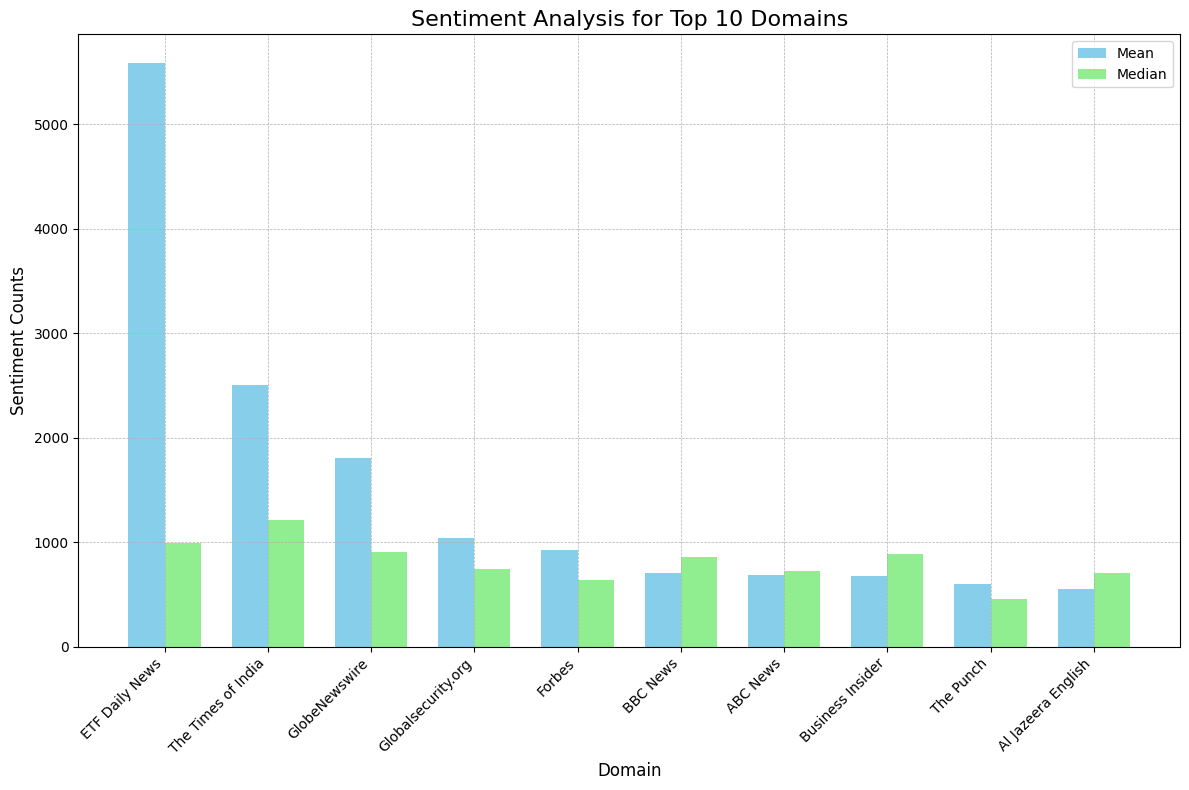

In [30]:
# Importing custom utilities
from src.utils import website_sentiment_distribution
from src.loader import NewsDataLoader



# Calculate sentiment distribution for websites
sentiment_counts = website_sentiment_distribution(news_data)

# Sort to find top domains based on total sentiment counts
top_domains = sentiment_counts.sort_values(by='Total', ascending=False).head(10)

# Function to plot grouped bar charts for sentiment analysis
def plot_grouped_sentiment(data, columns, title):
    # Set up the matplotlib figure and axes
    fig, ax = plt.subplots(figsize=(12, 8))
    bar_width = 0.35  # width of bars
    
    # Index for the bar positions
    index = np.arange(len(data))
    
    # Plotting
    bars1 = ax.bar(index, data[columns[0]], bar_width, label='Mean', color='skyblue')
    bars2 = ax.bar(index + bar_width, data[columns[1]], bar_width, label='Median', color='lightgreen')
    
    # Adding labels and title
    ax.set_xlabel('Domain', fontsize=12)
    ax.set_ylabel('Sentiment Counts', fontsize=12)
    ax.set_title(title, fontsize=16)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(data.index, rotation=45, ha='right', fontsize=10)
    
    # Adding a legend
    ax.legend()
    
    # Show grid
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Tight layout often provides a better fit
    plt.tight_layout()
    plt.show()

# Plot mean and median sentiment counts for the top domains
plot_grouped_sentiment(top_domains, ['Mean', 'Median'], 'Sentiment Analysis for Top 10 Domains')

<Figure size 1200x800 with 0 Axes>

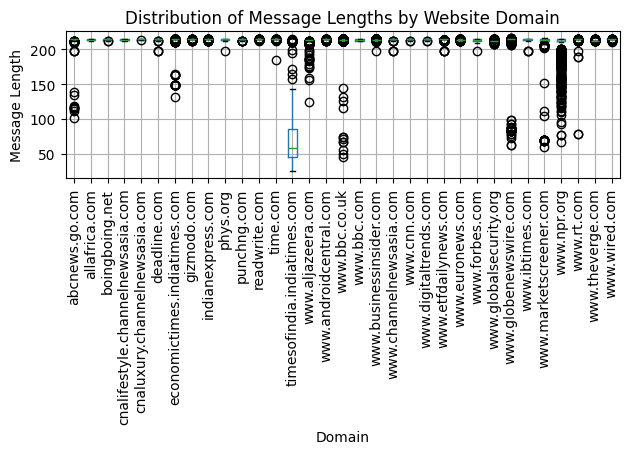

In [ ]:
# Calculate the length of each article/message in the DataFrame
ratingdf['message_length'] = ratingdf['content'].apply(len)  # Assuming 'content' holds the text; replace with 'article' if necessary

# Extract the base domain from URLs to use as the grouping variable
ratingdf['base_domain'] = ratingdf['url'].apply(lambda x: x.split('/')[2] if pd.notna(x) else None)

# Group by the base domain and describe the statistics of message lengths
lengths_by_domain = ratingdf.groupby('base_domain')['message_length'].describe()

# Visualize the distribution of message lengths for each domain using a boxplot
plt.figure(figsize=(12, 8))
ratingdf.boxplot(column='message_length', by='base_domain', rot=45)
plt.title('Distribution of Message Lengths by Website Domain')
plt.suptitle('')  # Remove the default subtitle to clean up the plot
plt.xlabel('Domain')
plt.ylabel('Message Length')
plt.xticks(rotation=90)  # Rotate domain names for better readability
plt.tight_layout()  # Adjust layout to make room for domain labels
plt.show()


C:\Users\Jojo\AppData\Local\Temp\ipykernel_32464\2185914180.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


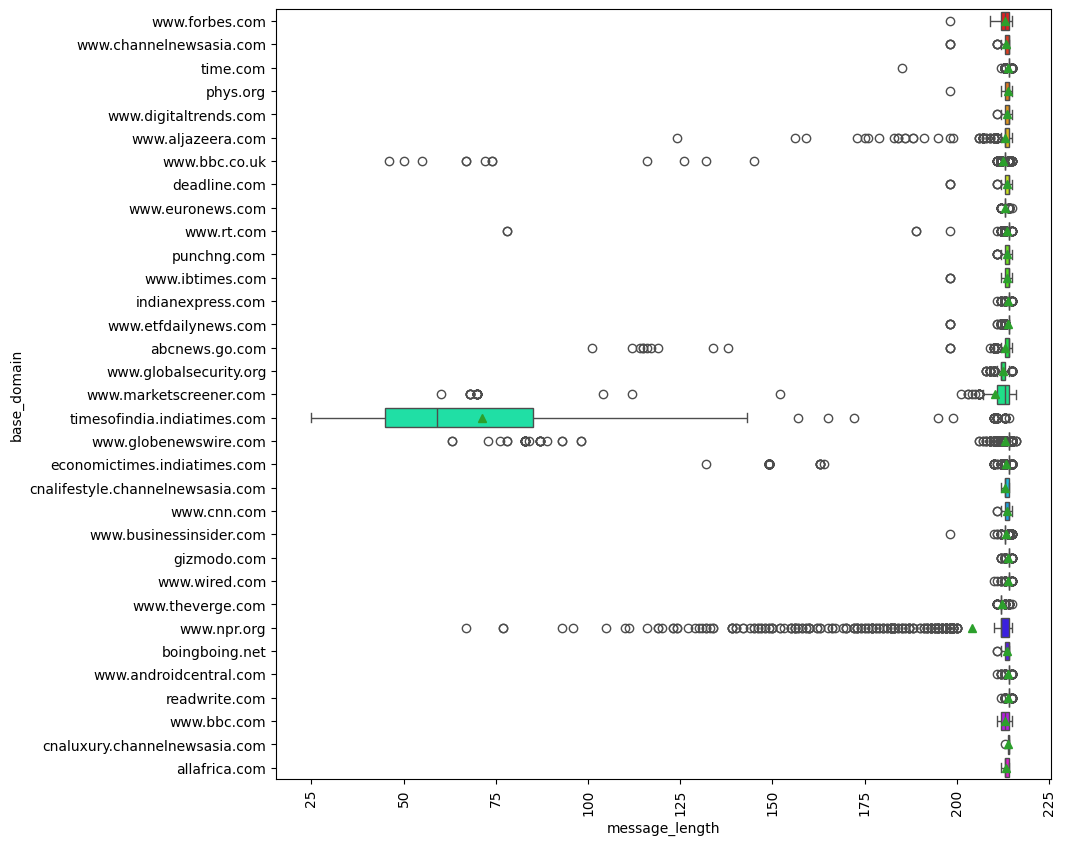

In [ ]:
plt.figure(figsize=(10, 10))
sns.boxplot(
    data=ratingdf, x='message_length', y="base_domain", palette="gist_rainbow", showmeans=True
)
plt.xticks(rotation=90)
plt.show()

## Data Preprocessing

- Missing value treatment
- Feature engineering (if needed)
- Outlier detection and treatment (if needed)
- Preparing data for modeling
- Any other preprocessing steps (if needed)